In [1]:
import torch
import os, sys
import tiktoken
import dataclasses

project_root = os.path.abspath(
    os.path.join(os.getcwd(), os.pardir, os.pardir)
)

stage1_root = os.path.join(project_root, "stage1")
sys.path.insert(0, stage1_root)

from src.gpt2small import GPTModel, GPTConfig124, generate_text


encoded: [32, 582, 1297, 502]
encoded_tensor: torch.Size([1, 4])
output: tensor([[   32,   582,  1297,   502, 24106, 40901, 46947, 45439, 41121, 10983,
         37408, 33219, 13597,   384, 41274, 27228, 32767,   972, 16051,  1462,
          6565, 26531, 19694, 30470]])
output length: 24
A man told me accumulation thumbnail Flask 406 propensity Hat lush Tulsolk se pandemonium 179 Hutement acresto emptyDa ISOetsu


In [2]:
cfg_pt = GPTConfig124()
print(dataclasses.asdict(cfg_pt))
torch.manual_seed(123)
model = GPTModel(cfg_pt)
model.eval()

{'vocab_size': 50257, 'context_length': 256, 'emb_dim': 768, 'n_heads': 12, 'n_layers': 12, 'dropout': 0.1, 'qkv_bias': False}


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_q): Linear(in_features=768, out_features=768, bias=False)
        (W_k): Linear(in_features=768, out_features=768, bias=False)
        (W_v): Linear(in_features=768, out_features=768, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_q): Linear(in_features=768, out_feat

In [3]:
def text_to_token_ids(text, tokenizer, allowed_special):
    """
    tensor.unsqueeze(dim) inserts a new axis (of size 1) at index dim.
    x = torch.tensor([10, 20, 30])       shape: [3]
    x0 = x.unsqueeze(0)                 shape: [1,3]
    x1 = x.unsqueeze(1)                 shape: [3,1]
    """
    allowed_special = allowed_special or ('<|endoftext|>')
    token_list = tokenizer.encode(text, allowed_special=set(allowed_special))
    ids = torch.tensor(token_list).unsqueeze(0)
    #unsqueeze turns a 1D sequence of token IDs into a 2D batch of size 1.
    #almost all pytorch nn.Modules (embeddings, transformers, etc.)
    # expect inputs of shape (batch_size, seq_len, ...)
    # even f we only have one example, we need to present it as a batch of size 1.
    return ids

def token_ids_to_text(token_ids, tokenizer):
    """
    tensor.squeeze(dim: optional) removes the axis at index dim if its size is 1.
    y = torch.zeros(1, 5, 1)         shape: [1,5,1]
    y0 = y.squeeze(0)               shape: [5,1]
    y1 = y.squeeze(2)               shape: [1,5]
    y2 = y.squeeze()               shape: [5] (all dims 1 are removed)
    """
    if not isinstance(token_ids, torch.Tensor):
        raise TypeError("token_ids must be a torch.Tensor")
    flat = token_ids.squeeze(0)
    #squeeze(0) just undoes the batch dimension we previously added,
    # giving back the raw token sequence.
    return tokenizer.decode(flat.tolist())

st_context = "A man told me"
tokenizer = tiktoken.get_encoding('gpt2')

token_ids = generate_text(
    model = model,
    idx = text_to_token_ids(st_context, tokenizer, allowed_special=None),
    max_new_tokens = 10,
    context_size = cfg_pt.context_length
)

print('Output text: ', token_ids_to_text(token_ids, tokenizer))

Output text:  A man told me accumulation thumbnail Flask 406 propensity Hat lush Tulsolk se


### Text Generation Loss

As can be seen from the output above, our model is producing random, non-coherent text. This is because it has not yet undergone training (and because the input size is very limited). Training is done in order to increase the softmax probability of the index positions that correspond to the correct target token position. A non-trained model will simply return the argmax of a rather arbitrary softmax distribution (random vectors) across the vocab size, for each token. The goal with training is then to maximize the chance of selecting the correct token by increasing its selection probability relative to other tokens.

In [19]:
text = """A man told me once that all the bad people
Were needed. Maybe not all, but your fingernails
You need; they are really claws, and we know
Claws. The sharks--what about them?
They make other fish swim faster. The hard-faced men
In black coats who chase you for hours
In dreams--that's the only way to get you
To the shore. Sometimes those hard women
Who abandon you get you to say, "You."
A lazy part of us is like a tumbleweed.
It doesn't move on its own. It takes sometimes
A lot of Depression to get tumbleweeds moving.
Then they blow across three or four States.
This man told me that things work together.
Bad handwriting sometimes leads to new ideas;
And a careless God--who refuses to let you
Eat from the Tree of Knowledge--can lead
To books, and eventually to us. We write
Poems with lies in them, but they help a little."""

tokens = text_to_token_ids(text, tokenizer, allowed_special=None)
print(f'Shape of tokens: {tokens.shape}')
print(f'Tokens:\n {tokens}')

B, T = 2, 4 #(batch_size, seq_len)
data = tokens[0][:8+1]

x = data[:-1].view(B,T) #input tensor
y = data[1:].view(B,T) #target tensor for next token prediction

print(f'Inputs:\n {x}')
print(f'Targets:\n {y}')

with torch.no_grad(): #we are not training yet, just an example
    logits = model(x)
probas = torch.softmax(logits, dim=-1)
print(probas.shape)


Shape of tokens: torch.Size([1, 212])
Tokens:
 tensor([[   32,   582,  1297,   502,  1752,   326,   477,   262,  2089,   661,
           198, 35653,  2622,    13,  6674,   407,   477,    11,   475,   534,
          8038,  1142,  1768,   198,  1639,   761,    26,   484,   389,  1107,
         28421,    11,   290,   356,   760,   198,  2601,  8356,    13,   383,
         27476,   438, 10919,   546,   606,    30,   198,  2990,   787,   584,
          5916,  9422,  5443,    13,   383,  1327,    12, 24903,  1450,   198,
           818,  2042, 30720,   508, 15505,   345,   329,  2250,   198,   818,
         10625,   438,  5562,   338,   262,   691,   835,   284,   651,   345,
           198,  2514,   262, 15191,    13,  8975,   883,  1327,  1466,   198,
          8241,  6871,   345,   651,   345,   284,   910,    11,   366,  1639,
           526,   198,    32, 16931,   636,   286,   514,   318,   588,   257,
         47978, 39054,    13,   198,  1026,  1595,   470,  1445,   319,   663,
     

Note that the dimension of the probability tensor is [2, 4, 50257], the same as the logits output shape of our model (batch_size, seq_len, d_model).

In [20]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print(token_ids)

tensor([[[12434],
         [22182],
         [22418],
         [24106]],

        [[ 9099],
         [30130],
         [40937],
         [34965]]])


The output above yields two sets of outputs, one for each batch in the inputs. Each element in each set is the predicted token IDs of the next word, from each word. Perhaps this is better explained visually.

In [21]:
preds = token_ids.squeeze(-1)
batch_size, seq_len = x.shape

for b in range(batch_size):
    for t in range(seq_len):
        inp_id = x[b,t].item()
        pred_id = preds[b,t].item()

        inp_tok = tokenizer.decode([inp_id])
        pred_tok = tokenizer.decode([pred_id])

        print(f"'{inp_tok}' [{inp_id}] ---> '{pred_tok}' [{pred_id}]")

'A' [32] ---> ' Driver' [12434]
' man' [582] ---> 'NP' [22182]
' told' [1297] ---> ' Munich' [22418]
' me' [502] ---> ' accumulation' [24106]
' once' [1752] ---> 'don' [9099]
' that' [326] ---> ' eagerly' [30130]
' all' [477] ---> ' dogma' [40937]
' the' [262] ---> ' ali' [34965]


In [22]:
print(f'Targets batch 1:\n {token_ids_to_text(y[0], tokenizer)}')
print(f'Outputs batch 1:\n {token_ids_to_text(token_ids[0].flatten(), tokenizer)}')
print(f'Targets batch 2: \n {token_ids_to_text(y[1], tokenizer)}')
print(f'Outputs batch 2:\n {token_ids_to_text(token_ids[1].flatten(), tokenizer)}')

Targets batch 1:
  man told me once
Outputs batch 1:
  DriverNP Munich accumulation
Targets batch 2: 
  that all the bad
Outputs batch 2:
 don eagerly dogma ali


As we can see, the model is producing very wrong, random texts that are vastly different from the target. We need to figure out a way to evaluate the performance of the model's generated text numerically through using some sort of loss metric. Using this loss, we can then implement a training function to robustly and iteratively update the model's weights and improve the generated text. But, in a context like language understanding and text generation, how do you build this loss? We want to measure how far, or how different the generated tokens are from the correct targets. But how do we embed this information in a function to optimize? How do you even begin to define inaccuracy or incorrectness in text generation, which might have no objectively correct next word?

In [23]:
y_1 = y[0].unsqueeze(1)
y_2 = y[1].unsqueeze(1)# (T,1)
target_probas_1 = probas[0].gather(dim=1, index=y_1).squeeze(1)
target_probas_2 = probas[1].gather(dim=1, index=y_2).squeeze(1)
print(f'The four target token ID probs for batch 1 are:\n', target_probas_1)
print(f'The four target token ID probs for batch 2 are:\n', target_probas_2)

The four target token ID probs for batch 1 are:
 tensor([7.7823e-06, 1.6688e-05, 1.7775e-05, 1.2489e-05])
The four target token ID probs for batch 2 are:
 tensor([1.1684e-05, 1.5996e-05, 8.7344e-06, 2.2723e-05])


To summarize our process thus far:

1. **Compute the raw mode outputs (logits).** These are the unnormalized scores that the GPT model assigns to every possible next token in its vocabulary. These reflect the model's relative confidence in each token before normalization.
2. **Normalize via softmax to obtain a probability distribution.** We convert the raw scores into a proper probability distribution over all tokens.
3. **Extract the probabilities of true next tokens.** For each position in every sequence of our batch, we index into the softmax output to retrieve the probability assigned to the actual (target) next token. This gives us a measure of how likely the model considers the correct continuation at each step.

Next, we will calculate the loss for the probability scores (one possible method) of our two example sentences by applying the logarithm to the probability scores.

In [24]:
target_probas = torch.cat((target_probas_1, target_probas_2))
log_probs = torch.log(target_probas)
print(f'Log probs:\n {log_probs}')

Log probs:
 tensor([-11.7637, -11.0008, -10.9377, -11.2907, -11.3573, -11.0432, -11.6482,
        -10.6921])


When we take the log of our model's predicted probabilities and use log-probabilities as the basis for our loss, we are constructing the (for relatively experienced readers) familiar negative-log-likelihood (or cross-entropy) objective that underpins many modern language models, and many other families of models as well. If our model assigns prob $p_{\theta}(y_t | x_{\lt t})$ to the correct next token $y_t$ given context $x_{\lt t}$, then the joint likelihood of a full sequence $y_{1:T}$ is the product:

$$
L(\theta) = \prod_{t=1}^{T} p_{\theta}(y_t | x_{\lt t})
$$

and maximizing this product directly is equivalent to maximizing its logarithm (since log is a strictly increasing function:

$$
\text{log}L(\theta) = \sum_{t=1}^{T} \text{log}\space p_{\theta}(y_t | x_{\lt t})
$$

So that minimizing $\mathcal{L}$ is exactly the same as maximizing the original likelihood $L$, we define the loss as the negative of this log-likelihood. It is this loss that we want to bring down to zero:

$$
\mathcal{L} = -\sum_{t=1}^{T} \text{log}\space p_{\theta}(y_t | x_{\lt t})
$$

We then average this quantity over batches and time-steps, but an essential insight remains: working with a sum of the logs of many small numbers is mathematically simpler to differentiate and numerically more stable than working with the product of these many small numbers. From a numerical standpoint, probabilities are bounded between 0 and 1, so when a model makes many predictions in a sequence the product of those probabilities can tend to really small numbers or underflow to zero. Taking the log of each probability allows us to work with numbers whose magnitudes grow linearly rather than exponentially, and floating-point addition is more stable than repeated multiplication of numbers less than one. Additionally, since log turns products into sums:

$$
\log({p_1 \times p_2 \times \dots \times p_T}) = \sum_{t=1}^{T}\log{p_t}
$$

we can compute loss for each time-step independently, aggregating them without the fear of catastrophic underflow. But beyond this stability, the log-loss also has compelling statistical and informational interpretations. In maximum likelihood estimation, one chooses model parameters $\theta$ to make the observed data as probable as possible; equivalently, one minimizes the negative log-likelihood. From an information theory, $-\log p_{\theta}(y)$ measures the 'surprise' of event $y$. When we minimize the expected $-\log p$, we are minimizing the Shannon cross-entropy between the true data distribution and our model's approximation. The cross-entropy is then a measure of the difference between two probability distributions.

On the optimizatin side, using a sum of log-probs yields gradients that emphasize mispredicted or low-probability events. If at time-step $t$ the model assigns probability $p_t$ to the correct token, then the derivative of $-\log p_t$ with respect to the underlying score is $\frac{-1}{p_t}$, so the smaller $p_t$, the larger the gradient magnitude.


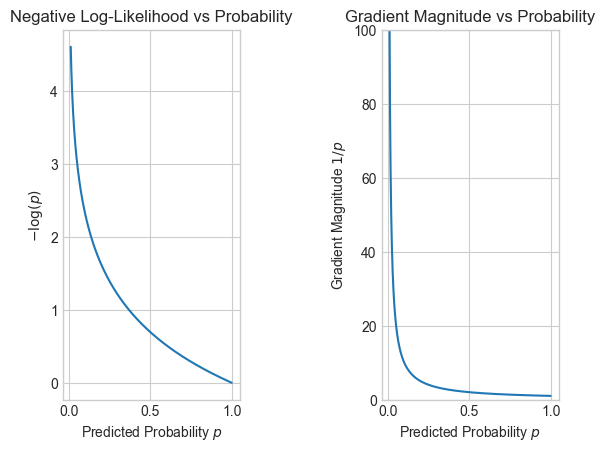

In [25]:
import numpy as np
import matplotlib.pyplot as plt


p = np.linspace(0.01, 1.0, 1000)
# Compute negative log-loss
neg_log = -np.log(p)

figure, axis = plt.subplots(1, 2)
axis[0].plot(p, neg_log)
axis[0].set_title('Negative Log-Likelihood vs Probability')
axis[0].set_xlabel('Predicted Probability $p$')
axis[0].set_ylabel('$-\\log(p)$')
axis[0].grid(True)

#-log(p): d(-log p)/dp = 1/p
grad_mag = 1 / p

axis[1].plot(p, grad_mag)
axis[1].set_title('Gradient Magnitude vs Probability')
axis[1].set_xlabel('Predicted Probability $p$')
axis[1].set_ylabel('Gradient Magnitude $1/p$')
axis[1].set_ylim(0, 100)  # limit y-axis for clarity
axis[1].grid(True)

figure.subplots_adjust(wspace=0.8)
plt.show()


Let's continue with our loss calculation by taking the average of the log probability scores, and then multiplying by -1.

In [26]:
avg_log_probas = torch.mean(log_probs)
print(avg_log_probas)
neg_avg_log_probas = -avg_log_probas
print(neg_avg_log_probas)

tensor(-11.2167)
tensor(11.2167)


In [27]:
logits_flat = logits.flatten(0, 1) #(batch_size, seq_len, d_model) --> (batch_size * seq_len, d_model)
y_flat = y.flatten() #(batch_size, seq_len) --> (batch_size * seq_len)
loss = torch.nn.functional.cross_entropy(logits_flat, y_flat)
print(f'Loss: {loss}')

Loss: 11.216712951660156


> As we can see above, PyTorch's built in `cross_entropy` function applies softmax on raw logits , selects the probabilites corresponding to target IDs for each token, and computes the negative average log probabilities. In other words, it does all the work for us.

#### Perplexity
Perplexity is, at its heart, a re-expression of cross-entropy in the original token domain rather than in log space. It essentially answers the question, *'On average, how many equally likely tokens would the model be as uncertain about as it is in reality?'*. When we train a language model we minimize the average negative log-likelihood per token, which is measures in natural logarithms, or bits (if we use base-2 logs). While this is the correct objective for maximum-likelihood estimation, a loss of, say, 10 natural logarithms per token can feel a bit too abstract. What does '10 units of suprise' mean, exactly? Perplexity is used to bridge that gap by exponentiating the average loss so that our metric lives back in the token domain:

$$
\text{Perplexity} = \text{exp}(\mathcal{L})
$$

If our model has perplexity of 50, we can say that, on average, it is as uncertain as if it had to choose uniformly among 50 tokens. A perfectly certain model (one that assigns a prob. of 1 to the correct next token) would have a cross-entropy loss of 0, and a perplexity of 1, reflecting zero uncertainty, exactly one choice. Exponentiating turns sums of logs (our loss) back into products of probabiliites. If cross-entropy is the arithmetic mean of 'surprise' ($-\log p$), then exponentiating this computes the geometric mean of $\frac{1}{p}$, which quantifies how 'wide' the model's distribution really is. In a way, it is telling us the model's effective vocabulary size given its actual uncertainty, and it therefore directly comparable across different datasets and tokenizations, as long as the vocabulary size is fixed.




In [28]:
perplexity = torch.exp(loss)
print(perplexity)

tensor(74362.9375)


### Training

 To compute the loss on a training and validation set, we will use "The Awakening, and Selected Short Stories" by Kate Chopin (2006). For readers with access to computers with more processing power or GPUs, the following experiments can be replicated using "Pride and Prejudice" by Jane Austen (1813), a significantly longer corpus. The full-books wers obtained from [Project Gutenberg](https://www.gutenberg.org/), and then converted to a .txt file via the epub2txt library.
 > Important: *These eBooks is for the use of anyone anywhere in the United States and most
other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this eBook or online
at www.gutenberg.org. If you
are not located in the United States, you will have to check the laws
of the country where you are located before using this eBook.*

In [4]:
pandp = '../../../data/pride_and_prejudice.txt'
short_stories = '../../../data/selected_shrt_stories.txt'
with open(pandp, "r", encoding="utf-8") as f1:
    text1 = f1.read()

with open(short_stories, "r", encoding="utf-8") as f2:
    text2 = f2.read()

character_num1 = len(text1)
tokens_num1 = len(tokenizer.encode(text1))
print(f'Number of characters in text: {character_num1}')
print(f'Number of tokens in text: {tokens_num1}')

character_num2 = len(text2)
tokens_num2 = len(tokenizer.encode(text2))
print(f'Number of characters in text: {character_num2}')
print(f'Number of tokens in text: {tokens_num2}')

Number of characters in text: 704415
Number of tokens in text: 177123
Number of characters in text: 63204
Number of tokens in text: 15743


Let's split the dataset to create a training set, and a separate validation set. We will then divide the tokenized text into pieces of a pre-defined length (`context_length` parameter). Note that, in practice, it is often beneficial to allow variable-length inputs to make our LLM generalize better across inputs of variable types and lengths.

We will use 85% of the data for training, and the remaining 15% as a validation set.

In [5]:
from src.load_data import create_dataloader

def split_text(text, ratio):
    """split raw text into training/val sets by char index"""
    split_point = int(ratio * len(text))
    train_data, val_data = text[:split_point], text[split_point:]
    return train_data, val_data

def build_loaders(text, cfg, batch_size=4, split_ratio=0.85, seed=123, num_workers=0):
    train_data, val_data = split_text(text, split_ratio)
    torch.manual_seed(seed)

    common_pars = dict(
        batch_size=batch_size,
        max_length=cfg.context_length,
        stride=cfg.context_length,
        num_workers=num_workers
    )

    train_loader = create_dataloader(
        train_data, shuffle=True, drop_last=True, **common_pars
    )
    val_loader = create_dataloader(
        val_data, shuffle=False, drop_last=False, **common_pars
    )
    return train_loader, val_loader

def print_loader_shapes(loaders):
    for name, loader in loaders.items():
        print(f'{name.capitalize()} loader:')
        for i, (x, y) in enumerate(loader, start=1):
            print(f'Batch #{i}: x.shape={x.shape}, y.shape={y.shape}')
        print()

train_loader_, val_loader_ = build_loaders(text1, cfg_pt)
print_loader_shapes({'train':train_loader_,
                    'validation':val_loader_})

train_loader, val_loader = build_loaders(text2, cfg_pt)

Train loader:
Batch #1: x.shape=torch.Size([4, 256]), y.shape=torch.Size([4, 256])
Batch #2: x.shape=torch.Size([4, 256]), y.shape=torch.Size([4, 256])
Batch #3: x.shape=torch.Size([4, 256]), y.shape=torch.Size([4, 256])
Batch #4: x.shape=torch.Size([4, 256]), y.shape=torch.Size([4, 256])
Batch #5: x.shape=torch.Size([4, 256]), y.shape=torch.Size([4, 256])
Batch #6: x.shape=torch.Size([4, 256]), y.shape=torch.Size([4, 256])
Batch #7: x.shape=torch.Size([4, 256]), y.shape=torch.Size([4, 256])
Batch #8: x.shape=torch.Size([4, 256]), y.shape=torch.Size([4, 256])
Batch #9: x.shape=torch.Size([4, 256]), y.shape=torch.Size([4, 256])
Batch #10: x.shape=torch.Size([4, 256]), y.shape=torch.Size([4, 256])
Batch #11: x.shape=torch.Size([4, 256]), y.shape=torch.Size([4, 256])
Batch #12: x.shape=torch.Size([4, 256]), y.shape=torch.Size([4, 256])
Batch #13: x.shape=torch.Size([4, 256]), y.shape=torch.Size([4, 256])
Batch #14: x.shape=torch.Size([4, 256]), y.shape=torch.Size([4, 256])
Batch #15: x.sh

As can be seen in the output above, for Pride and Prejudice, a 85/15 training/validation split yields 146 training batches, with 4 samples and 256 tokens each. We also have 26 validation batches, also consisting of 4 examples and 256 tokens each. Note also that the input x and target y are of the same shape (since the targets are just the inputs shifted by a single position). Let's now calculate the cross-entropy loss for a given batch.

From this point onwards, we will use "The Awakening, and Selected Short Stories" by Kate Chopin, simply due to the fact that my computer can't train this model on a corpus as big as "Pride and Prejudice" at a convenient speed.

In [6]:
def calc_loss_cross_entropy(logits, target):
    """
    logits.shape == (batch_size, sequence_length, vocab_size)
    targets.shape == (batch_size, sequence_length)
    """
    flat_logits = logits.flatten(0, 1) #(batch_size*seq_len, vocab)
    flat_targets = target.flatten(0) #(batch_size*seq_len)
    return torch.nn.functional.cross_entropy(flat_logits, flat_targets)


def eval_loss(data_loader, model, device, max_batches=None):
    """
    run model.eval() and return average cross-entropy loss over up to max_batches(optional)
    """
    model.eval()
    total, count = 0.0, 0
    with torch.no_grad():
        for i, (x, y) in enumerate(data_loader):
            if max_batches is not None and i >= max_batches:
                break
            x, y = x.to(device), y.to(device)
            logits = model(x)
            total += calc_loss_cross_entropy(logits, y).item()
            count += 1
    return float('nan') if count == 0 else total / count

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
train_loss = eval_loss(train_loader, model, device)
val_loss = eval_loss(val_loader, model, device)
print(f"Train loss: {train_loss}")
print(f"Valid loss: {val_loss}")

Train loss: 10.968981901804606
Valid loss: 10.977005958557129


In [7]:
print(f'Training perplexity: {torch.exp(torch.tensor(train_loss))}')
print(f'Validation perplexity: {torch.exp(torch.tensor(val_loss))}')

Training perplexity: 60217.49609375
Validation perplexity: 59467.09375


As shown above, the loss values are very high, reflecting the fact that the model has not been trained. At least we now have a way to measure the quality of the text that is generated, and can now proceed to methodologicaly train the LLM to reduce this loss and improve our model!

In [7]:
import time
from tqdm.auto import tqdm

def eval_losses(model, loaders, device, max_batches):
    model.eval()
    losses = {}
    with torch.no_grad():
        for split, loader in loaders.items():
            losses[split] = eval_loss(loader, model, device, max_batches)
    model.train()
    return losses

def generate_sample(model, tokenizer, device, prompt):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    input_ids = text_to_token_ids(prompt, tokenizer, allowed_special=None).to(device)
    with torch.no_grad():
        output_ids = generate_text(model=model, idx=input_ids, max_new_tokens=50, context_size=context_size)
    text = token_ids_to_text(output_ids, tokenizer).replace("\n", " ")
    print(text)
    model.train()

def train_model(model, train_loader, val_loader,
                optimizer, device, num_epochs,
                eval_freq, eval_iter, sample_prompt, tokenizer):
    history = {
        "steps": [],
        "train_loss": [],
        "val_loss": []
    }
    model.to(device)
    global_step = 0
    tokens_seen = 0

    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_start = time.time()
        pbar = tqdm(train_loader, desc=f'Epoch {epoch}/{num_epochs}')
        for x,y in pbar:
            global_step += 1
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            logits = model(x)
            loss = calc_loss_cross_entropy(logits, y)
            loss.backward()
            optimizer.step()
            tokens_seen += x.numel()
            pbar.set_postfix(loss=loss.item())

            #periodic evaluation
            if global_step % eval_freq == 0:
                #train_l = eval_loss(train_loader, model, device, max_batches=eval_iter)
                #val_l = eval_loss(val_loader, model, device, max_batches=eval_iter)
                losses = eval_losses(
                    model,
                    {'train': train_loader, 'val': val_loader},
                    device,
                    eval_iter
                )
                history['steps'].append(global_step)
                history['train_loss'].append(losses['train'])
                history['val_loss'].append(losses['val'])
                print(f'[Step {global_step}], Train CE={losses["train"]}, Val CE={losses["val"]}, Tokens seen={tokens_seen}')

                if sample_prompt and tokenizer:
                    print("--> Sample generation:")
                    generate_sample(model, tokenizer, device, sample_prompt)

        epoch_time = time.time() - epoch_start
        print(f'Epoch {epoch} done in {epoch_time} seconds')
    return history

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)
num_epochs = 10
torch.manual_seed(123)

In [35]:
history = train_model(model, train_loader, val_loader,
                      optimizer, device=device, num_epochs=num_epochs,
                      eval_freq = 10, eval_iter =5, sample_prompt="A man once told me",
                      tokenizer=tokenizer)

Epoch 1/10:   0%|          | 0/12 [00:00<?, ?it/s]

[Step 10], Train CE=6.996414089202881, Val CE=7.440126180648804, Tokens seen=10240
--> Sample generation:
A man once told me. . . . . . . . . . . . . . . . . . . . . . . . . 
Epoch 1 done in 74.3529908657074 seconds


Epoch 2/10:   0%|          | 0/12 [00:00<?, ?it/s]

[Step 20], Train CE=6.085464286804199, Val CE=7.110649108886719, Tokens seen=20480
--> Sample generation:
A man once told me, and the ” ” ” ” ” ” ” ” ” ” ” ” the ” ” ” 
Epoch 2 done in 67.03633999824524 seconds


Epoch 3/10:   0%|          | 0/12 [00:00<?, ?it/s]

[Step 30], Train CE=5.863742637634277, Val CE=7.040201663970947, Tokens seen=30720
--> Sample generation:
A man once told me to the ” ” ” ” ” ” ” ” ” ” ” ” ” ” ” ”
Epoch 3 done in 68.32929015159607 seconds


Epoch 4/10:   0%|          | 0/12 [00:00<?, ?it/s]

[Step 40], Train CE=5.735688018798828, Val CE=7.01276159286499, Tokens seen=40960
--> Sample generation:
A man once told me The the�s. The to the The which The a�s. The a little was a�s The a little the The the The a�s. The a little. Mrs. 
Epoch 4 done in 66.72336196899414 seconds


Epoch 5/10:   0%|          | 0/12 [00:00<?, ?it/s]

[Step 50], Train CE=5.249767303466797, Val CE=6.898496866226196, Tokens seen=51200
--> Sample generation:
A man once told me The. Pontellier, and The. Pontellier, and The the The theier was a The The the The The The The The. Pontellier, and The The
[Step 60], Train CE=5.001570034027099, Val CE=6.870227575302124, Tokens seen=61440
--> Sample generation:
A man once told me ” ” ” ” he had ” ” ” ” ” ” ” he had. ” he had. ” ”
Epoch 5 done in 78.21673583984375 seconds


Epoch 6/10:   0%|          | 0/12 [00:00<?, ?it/s]

[Step 70], Train CE=4.589968967437744, Val CE=6.732833385467529, Tokens seen=71680
--> Sample generation:
A man once told me to ’s. ” “I. “I. “I was a little to the “I “I’s. “I, and “I
Epoch 6 done in 68.35888528823853 seconds


Epoch 7/10:   0%|          | 0/12 [00:00<?, ?it/s]

[Step 80], Train CE=3.9849631786346436, Val CE=6.707085132598877, Tokens seen=81920
--> Sample generation:
A man once told me the and the ” ” ” ” ” ” ” ” ” ” ” ” ” he was a ” 
Epoch 7 done in 68.58648681640625 seconds


Epoch 8/10:   0%|          | 0/12 [00:00<?, ?it/s]

[Step 90], Train CE=3.5980672359466555, Val CE=6.719225883483887, Tokens seen=92160
--> Sample generation:
A man once told me to ’s “I, and “I had been. “I’s!“You was not have been a “You“I. “I“I�
Epoch 8 done in 67.70622110366821 seconds


Epoch 9/10:   0%|          | 0/12 [00:00<?, ?it/s]

[Step 100], Train CE=3.08915319442749, Val CE=6.718594789505005, Tokens seen=102400
--> Sample generation:
A man once told me to ” he had been. ” he had no to the ” he had been a ” he had. ” he had ” he had been a little,” he had been a 
Epoch 9 done in 71.67139196395874 seconds


Epoch 10/10:   0%|          | 0/12 [00:00<?, ?it/s]

[Step 110], Train CE=2.582422399520874, Val CE=6.735230922698975, Tokens seen=112640
--> Sample generation:
A man once told me a little, and pressed his suit with a the and an her. the, and the water-oaks, and the beach was a little the ’s hotel. ” he had a little ” she
[Step 120], Train CE=2.273233509063721, Val CE=6.8327696323394775, Tokens seen=122880
--> Sample generation:
A man once told me a bitter her of the depths of the other conven. Pontellier had been dead. “Oh,“You trimmed. ” she spread upon the water. ’s and some speculation. “I
Epoch 10 done in 90.81413412094116 seconds


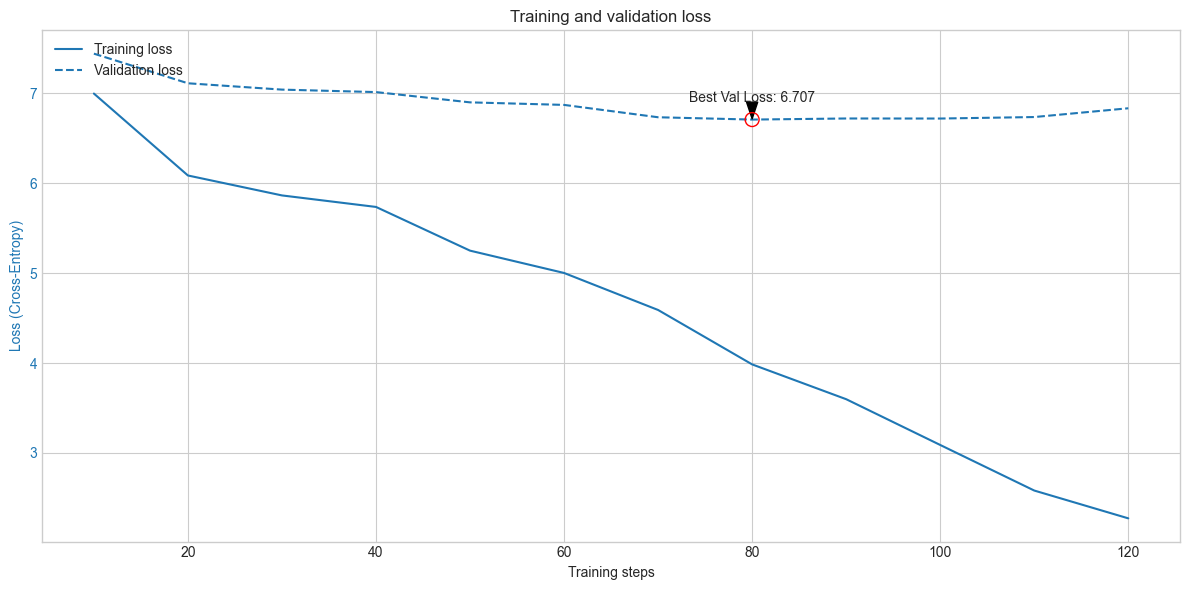

In [47]:
import matplotlib.pyplot as plt
import numpy as np

best_val_loss_step = history['steps'][np.argmin(history['val_loss'])]
best_val_loss = min(history['val_loss'])

fig, ax1 = plt.subplots(figsize=(12, 6))
plt.style.use('seaborn-v0_8-whitegrid')
color = 'tab:blue'
ax1.set_xlabel('Training steps')
ax1.set_ylabel('Loss (Cross-Entropy)', color=color)
ax1.plot(history['steps'],history['train_loss'],color=color, linestyle='-', label='Training loss')
ax1.plot(history['steps'],history['val_loss'],color=color, linestyle='--', label='Validation loss')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

# Annotate the best validation loss
ax1.annotate(f'Best Val Loss: {best_val_loss:.3f}',
             xy=(best_val_loss_step, best_val_loss),
             xytext=(best_val_loss_step, best_val_loss + 0.2),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8),
             ha='center')
ax1.scatter(best_val_loss_step, best_val_loss, s=100, facecolors='none', edgecolors='r', zorder=5)

plt.title('Training and validation loss')
fig.tight_layout()
plt.show()



In [37]:
torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()},
           'model_and_optimizer.pth')

The most important conclusion from this training run is that our model is severely overfitting the training data. While it is successfully learning (see the training loss going down monotonically), it seems to be learning to memorize our small training corpus rather than generalizing the rules of the English language (see the validation loss quickly plateauing and diverging from the training loss). The growing chasm between the training and validation loss curves represent the model's failure to generalize. It is becoming an expert on a book it has read a thousand times, but is increasingly unable to write a new one.

Another way to think about is that there is a fundamental mismatch between model capacity and data volume. Our model is too powerful for the tiny dataset (~1000 lines), and it has so many parameters that it can just take the easier path of simply memorizing the entire dataset. To improve training, we could:

- **Drastically increase dataset size.** Our corpus is perhaps better suited for a simple n-gram model, but trivial for a LLM. Indeed, it is common to use datasets 1000x larger or more.
- **Implement early stopping**, since our validation loss fails to improve after step ~75.
- **Strengthen regularization** through more dropout, weight decay, etc.

In [8]:
checkp = torch.load('model_and_optimizer.pth', map_location=device)
model = GPTModel(cfg_pt)
model.load_state_dict(checkp['model_state_dict'])
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)
optimizer.load_state_dict(checkp['optimizer_state_dict'])
model.train()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_q): Linear(in_features=768, out_features=768, bias=False)
        (W_k): Linear(in_features=768, out_features=768, bias=False)
        (W_v): Linear(in_features=768, out_features=768, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_q): Linear(in_features=768, out_feat

### Decoding Strategies

Our decoding strategy is extremely important in determining the quality and character of the generated text. Nearly all decoding strategies are trying to solve a fundamental dilemma: We want text that is grammatically correct, makes sense, and stays on topic (Coherence/Quality), but we also want text that is interesting, surprising, and does not just repeat the most obvious phrases or the most repeated structures (Diversity/Creativity). A purely greedy approach might lead to perfect coherence, but with repetitive and boring results. Introducing randomness might help, but too much of it will leaad to incoherent nonsense. Below, we explore some of the most popular decoding strategies.

#### Temperature Scaling

This strategy adjusts the 'sharpness' of the probability distribution, aiming to make it more or less random. Recalling that we originally passed the model's raw output (logits) to the softmax function, temperature scaling divides them by a temperature value $T \gt 0$ before passing them to the softmax function.

$$
P(\text{token}_i) = \text{softmax}\left(\frac{\text{logits}}{T}\right)_i = \frac{e^{\text{logit}_i / T}}{\sum_j e^{\text{logit}_j / T}}
$$

- $T \approx 0$: Approaches greedy decoding. The highest logit would become overwhelmingly and extremely probable. The output is deterministic (the LLM will always generate the same results for the same prompt). This is our current setting (with no decoding strategy).
- $T = 1$: The original probability with the default softmax function is recovered. This is our current setting (with no decoding strategy).
- $T > 1$: The recalibrated, new probabilities will have a lower value compared to the original ones. The distribution is flattened, and unlikely tokens become more likely. The output is more random, and therefore more prone to errors.

While temperature scaling can be used as a hyperparameter set manually at inference time (`generate_text`), it can also be used to calibrate the model post-hoc. That is, $T$ can be optimized once on a held-out validation set after the main training is complete. The found optimal $T$ is then fixed and used as part of the model for all subsequent inference.

tensor([ 3.0353, -4.6372, -3.5927,  ..., -4.3146, -4.4531, -4.7166])


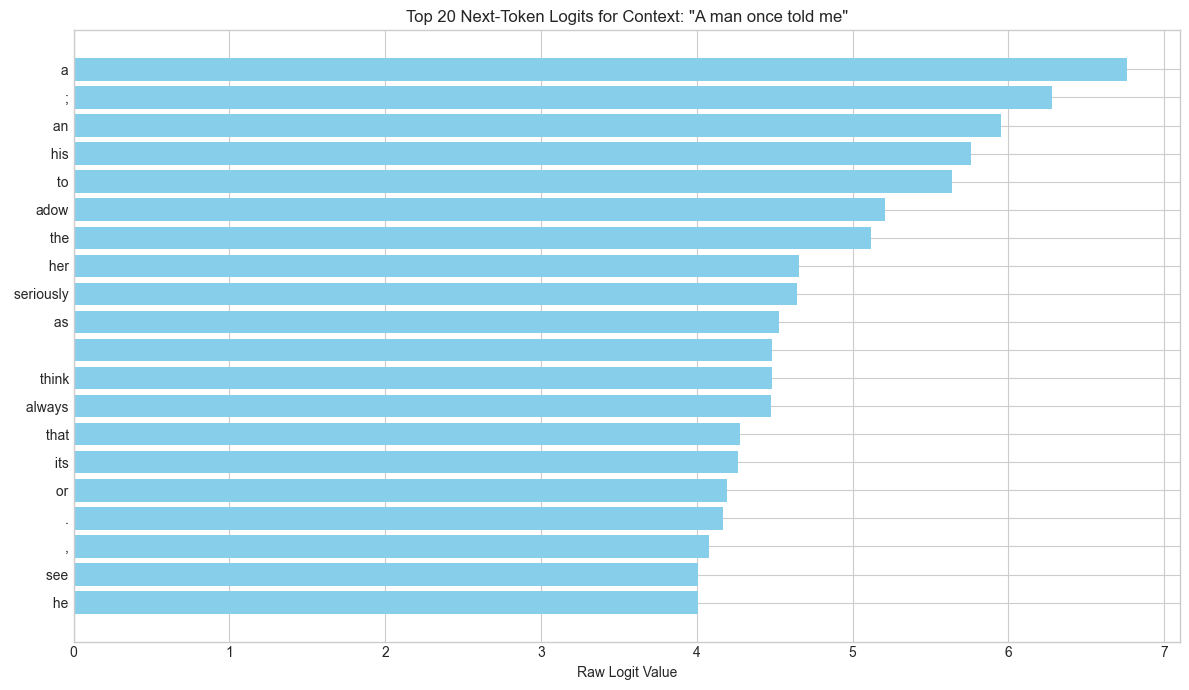

In [49]:
import matplotlib.pyplot as plt
import numpy as np

def get_next_token_logits(model, tokenizer, context, device):
    """
    Get the logits for the next token prediction.
    """
    model.eval()
    with torch.no_grad():
        inputs = text_to_token_ids(context, tokenizer, allowed_special=None).to(device)
        outputs = model(inputs)
        next_token_logits = outputs[0, -1, :]
    return next_token_logits
        # return_tensors = 'pt' wil return torch.Tensors objects instead of py lists.

logits = get_next_token_logits(model, tokenizer, 'A man once told me', device)
print(logits)
top_logits, top_indices = torch.topk(logits, 20)
# get the top 20 logits and their corresponding tokens
top_tokens = []
for idx in top_indices:
    #have to use single tokens here for the helper functions to work.
    #it is easier not to reuse them here perhaps...
    single_token_tensor = torch.tensor([[idx.item()]])
    decoded_token = token_ids_to_text(single_token_tensor, tokenizer)
    top_tokens.append(decoded_token)

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 7))
y_pos = np.arange(len(top_tokens))
ax.barh(y_pos, top_logits.cpu().numpy(), align='center', color='skyblue')
ax.set_yticks(y_pos, labels=top_tokens)
ax.invert_yaxis()
ax.set_xlabel('Raw Logit Value')
ax.set_title(f'Top 20 Next-Token Logits for Context: "A man once told me"')
plt.tight_layout()
plt.show()



--- Multinomial Sampling (T=1.0, n=1000) ---
The most likely token ' a' was chosen 252 out of 1000 times.
This is 25.20% of the total samples.
--------------------------------------------------


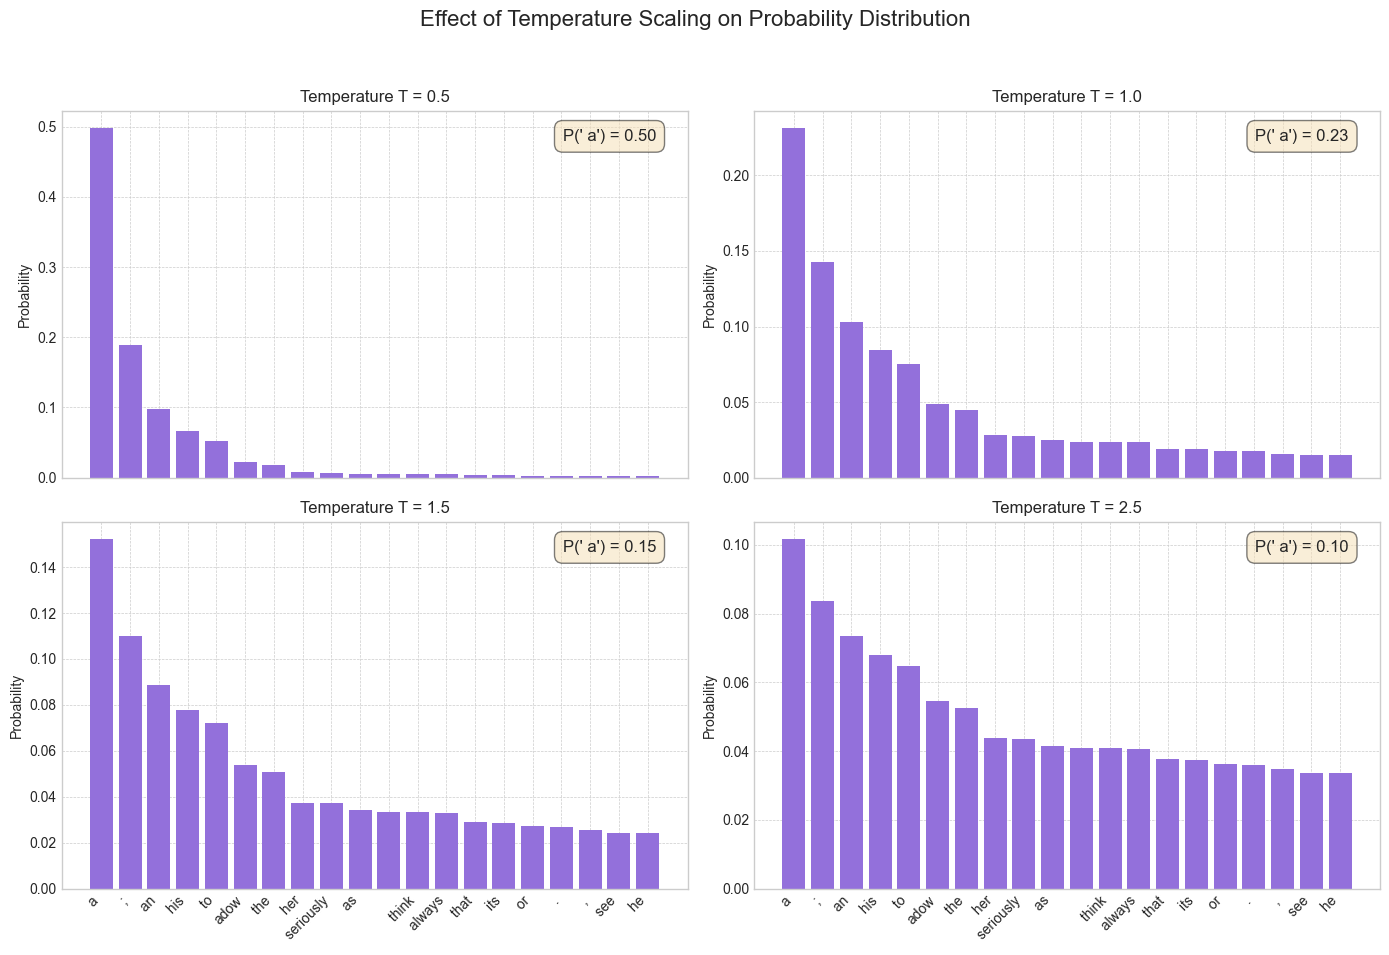

In [50]:
n_samples = 1000
probabilities = torch.softmax(top_logits, dim=-1)
sampled_indices = torch.multinomial(probabilities, n_samples, replacement=True)
sample_counts = torch.bincount(sampled_indices, minlength=20)
most_likely_token = top_tokens[0]
most_likely_count = sample_counts[0].item()

print(f"\n--- Multinomial Sampling (T=1.0, n={n_samples}) ---")
print(f"The most likely token '{most_likely_token}' was chosen {most_likely_count} out of {n_samples} times.")
print(f"This is {most_likely_count / n_samples:.2%} of the total samples.")
print("-" * 50)

t_values = [0.5, 1.0, 1.5, 2.5]
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)
fig.suptitle(f'Effect of Temperature Scaling on Probability Distribution', fontsize=16)

for ax, T in zip(axes.flatten(), t_values):
    scaled_logits = top_logits / T
    scaled_probabilities = torch.softmax(scaled_logits, dim=-1).cpu().numpy()

    ax.bar(y_pos, scaled_probabilities, color='mediumpurple')
    ax.set_title(f'Temperature T = {T}')
    ax.set_xticks(y_pos)
    ax.set_xticklabels(top_tokens, rotation=45, ha="right")
    ax.set_ylabel('Probability')
    ax.grid(True, which='major', linestyle='--', linewidth='0.5')

    prob_top_token = scaled_probabilities[0]
    ax.text(0.95, 0.95, f"P('{most_likely_token}') = {prob_top_token:.2f}",
            transform=ax.transAxes,
            fontsize=12, verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#### Top-k Sampling

A weakness of pure temperature scaling that you might have inferred from the plots above is the 'long tail' of potentially terrible token choices that can get sampled by change when the temperature is high. *Top-k sampling* is a slight variation from temperature scaling in that it adds a constraint on how many most likely tokens $k$ to consider, and only redistributes the probability mass among these. In other words, it implements the exact same masking approach we have already implemented before in the causal attention module. Top-k sampling

In [51]:
for t in t_values:
    logits = logits / t
    top_k_logits, top_k_indices = torch.topk(logits, 10, dim=-1)
    probs = torch.softmax(top_k_logits, dim=-1)
    next_token_idx_in_k = torch.multinomial(probs, num_samples=1)
    next_token_id = torch.gather(top_k_indices, -1, next_token_idx_in_k)
    print(f'Next-token probabilities with t_value {t} and k = 10:\n{probs}')
    print(f'Next_token_idx_in_k and k = 10 {next_token_idx_in_k}')


Next-token probabilities with t_value 0.5 and k = 10:
tensor([0.5158, 0.1955, 0.1018, 0.0691, 0.0545, 0.0231, 0.0191, 0.0077, 0.0075,
        0.0059])
Next_token_idx_in_k and k = 10 tensor([0])
Next-token probabilities with t_value 1.0 and k = 10:
tensor([0.5158, 0.1955, 0.1018, 0.0691, 0.0545, 0.0231, 0.0191, 0.0077, 0.0075,
        0.0059])
Next_token_idx_in_k and k = 10 tensor([3])
Next-token probabilities with t_value 1.5 and k = 10:
tensor([0.3628, 0.1901, 0.1230, 0.0950, 0.0811, 0.0458, 0.0404, 0.0219, 0.0216,
        0.0183])
Next_token_idx_in_k and k = 10 tensor([0])
Next-token probabilities with t_value 2.5 and k = 10:
tensor([0.1866, 0.1441, 0.1210, 0.1092, 0.1025, 0.0815, 0.0775, 0.0607, 0.0603,
        0.0566])
Next_token_idx_in_k and k = 10 tensor([2])


#### Top-p (Nucleus) Sampling

Top-p samping is today perhaps the most popular sampling method in modern use, and it was first introduced in the paper *The Curious Case of Neural Text DeGeneration* (Holtzman et.al, 2020).

Top-p improves upon Top-k by creating a candidate pool of dynamic size. Now, instead of picking a fixed number of tokens ($k$), we pick the smallest set of most probable tokens whose cumulative probability is greather than a threshold $p$. This set is called the Nucleus. It is powerful because of its adaptiveness: when the model is very confident about the next token (a very sharp distribution), the nucleus will contain 1 or 2 tokens. When the model is uncertain (a flatter distribution), the nucleus will grow much larger, allowing for more diversity when it is needed.

In [9]:
def generate_text_better(model, idx, max_new_tokens,
                         context_size,temperature,
                         k, p, eos_id=None):
    device = next(model.parameters()).device
    generated = idx.to(device)
    with torch.inference_mode():
        for _ in range(max_new_tokens):
            context = generated[:, -context_size:]
            with torch.no_grad():
                logits = model(context)[:,-1, :]
            logits /= max(temperature, 1e-8) #avoid division by zero
            if k > 0:
                top_k_values, _ = torch.topk(logits, k)
                # the last value in top_k_values is the k-th highest logit
                kth_value = top_k_values[:, -1]
                # create a mask for all tokens with logits less tha the k-th highest
                indices_to_remove = logits < kth_value[:, None]
                logits[indices_to_remove] = -float('Inf')

            # on the reduced set of logits, we apply the top-p filtering
            if p is not None and p < 1.0:
                probs = torch.softmax(logits, dim=-1)
                sorted_probs, sorted_indices = torch.sort(probs, descending=True)
                cum_probs = torch.cumsum(sorted_probs, dim=-1)

                #we now want to create a mask for tokens to remove (those outside this nucleus)
                # find tokens whose cum sum is > p
                sorted_indices_to_remove = cum_probs > p
                # shift the mask to the right to keep the first token that crosses the threshold
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
                sorted_indices_to_remove[..., 0] = 0 #never remove the most likely token

                #create a full-sized boolean mask for og logits
                #start with a mask of all false values
                indices_to_mask = torch.zeros_like(logits, dtype=torch.bool)

                #use scatter_ to place the 'True' values from 'sorted_indices_to_remove'
                # into the correct positions in the full-sized mask
                indices_to_mask.scatter_(1, sorted_indices, sorted_indices_to_remove)
                logits[indices_to_mask] = -float('Inf')


            final_probs = torch.softmax(logits, dim=-1)
            next_token = torch.multinomial(final_probs, num_samples=1)
            if next_token == eos_id:
                break
            generated = torch.cat([generated, next_token], dim=1)
    return generated

torch.manual_seed(123)

token_ids = generate_text(
    model=model,
    idx=text_to_token_ids('A man walks into a bar',
                          tokenizer,
                          allowed_special='<|endoftext|>'),
    max_new_tokens=20,
    context_size=cfg_pt.context_length,
)

token_ids_better = generate_text_better(model=model,
                                 idx=text_to_token_ids('A man walks into a bar',
                                                       tokenizer,
                                                       allowed_special='<|endoftext|>'),
                                 max_new_tokens=20,
                                 context_size=cfg_pt.context_length,
                                 k=200,
                                 p=0.9,
                                 temperature=1.4)

print('Original output text:', token_ids_to_text(token_ids, tokenizer))
print('Improved output text:', token_ids_to_text(token_ids_better, tokenizer))

Original output text: A man walks into a bar and a little, and
’s eyes. Pontellier.
”
�
Improved output text: A man walks into a bar from a queer of compliments sometimes held of what to feel is Ad froming. Two far when must


As can be seen, the generated text varies considerably between our original 'vanilla' text generation and the one using temperature, top-k and top-p decoding strategies. Indeed, tunning the right parameters is key to achieving desired outputs from LLMs, and these parameters together control the level of randomness and creativity in the text an LLM generates.

In general, a preference for lower temperature alongside more restrictive top-k and top-p settings is seen in scenarios that are demanding of accuracy, coherence and predictability (Factual summarization, question answering, code generation, technical writing, translation, etc.), and in domains where precision and correctness are non-negotiable. In the other hand, situations calling for originality and novelty benefit from relatively higher temperatures and less restrictive top-k or top-p settings (Creative writing, story generation, brainstorming, artistic and poetic text, content creation for marketing and social media, etc.).

### Using OpenAIs Pretrained Weights

We use the download code available in Sebastian Raschka's online repository of Chapter 6 of *LLMs from Scratch*.



In [10]:
import urllib.request

url = (
    'https://raw.githubusercontent.com/rasbt/'
    'LLMs-from-scratch/main/ch05/'
    '01_main-chapter-code/gpt_download.py'
)
filename = '../src/gpt_download.py'
urllib.request.urlretrieve(url, filename)

('gpt_download.py', <http.client.HTTPMessage at 0x121728550>)

In [11]:
from gpt_download import download_and_load_gpt2

settings, params = download_and_load_gpt2(
    model_size='124M', models_dir='gpt2',
)

2025-06-28 19:41:35.096036: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


In [13]:
print(f'Settings: {settings}\nParam dictionary keys: {params.keys()}')

gpt2_sizes = {
    'gpt2-small (124M)': {'emb_dim': 768, 'n_layers': 12, 'n_heads': 12},
    'gpt2-medium (355M)': {'emb_dim': 1024, 'n_layers': 24, 'n_heads': 16},
    'gpt-large (774M)': {'emb_dim': 1280, 'n_layers': 48, 'n_heads': 25},
}

model_name = 'gpt2-small (124M)'
config_args = dataclasses.asdict(cfg_pt)
config_args.update(gpt2_sizes[model_name])
config_args.update({'context_length': 1024, 'qkv_bias':True})
print(config_args)
new_cfg = GPTConfig124(**config_args)
gpt = GPTModel(new_cfg)
gpt.eval()


Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Param dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])
{'vocab_size': 50257, 'context_length': 1024, 'emb_dim': 768, 'n_heads': 12, 'n_layers': 12, 'dropout': 0.1, 'qkv_bias': True}


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_q): Linear(in_features=768, out_features=768, bias=True)
        (W_k): Linear(in_features=768, out_features=768, bias=True)
        (W_v): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_q): Linear(in_features=768, out_featur

Since a `GPTModel` instance by default initializes weights to be random, we need to override these random weights with the ones stored in the `params` dictionary earlier.

In [20]:
import numpy as np

def load_weights_from_openai(gpt_model, openai_params):
    """
    load pre-trained GPT2 weights from openai's format into our custom model.
    """
    with torch.no_grad():
        def copy_weights(pytorch_param, numpy_array):
            """
            helper to handle shape checking and data copying
            """
            numpy_tensor = torch.from_numpy(numpy_array).to(pytorch_param.dtype)
            if pytorch_param.shape != numpy_tensor.shape:
                raise ValueError(
                    f'Shape mismatch: Pytorch odel has {pytorch_param.shape}, '
                    f'but loaded weights have {numpy_tensor.shape}')
            #copy_ is an in-place operation that avoids creating new parameter objects
            pytorch_param.copy_(numpy_tensor)
        #wte are the token embeddings
        copy_weights(gpt_model.tok_emb.weight, openai_params['wte'])
        #wpe are the positional embeddings
        copy_weights(gpt_model.pos_emb.weight, openai_params['wpe'])

        #iterate through each blovk in the model and load its weights
        for block_module, block_params in zip(gpt_model.trf_blocks, openai_params['blocks']):
            q_w, k_w, v_w = np.split(block_params['attn']['c_attn']['w'], 3, axis=-1)
            q_b, k_b, v_b = np.split(block_params['attn']['c_attn']['b'], 3, axis=-1)
            # openai's 'c_attn' combines q, k and v weights into a single matrix.
            # their linear layer weights are transposed compared to pytorch
            copy_weights(block_module.att.W_q.weight, q_w.T)
            copy_weights(block_module.att.W_k.weight, k_w.T)
            copy_weights(block_module.att.W_v.weight, v_w.T)

            copy_weights(block_module.att.W_q.bias, q_b)
            copy_weights(block_module.att.W_k.bias, k_b)
            copy_weights(block_module.att.W_v.bias, v_b)

            #output projection weights
            copy_weights(block_module.att.out_proj.weight, block_params['attn']['c_proj']['w'].T)
            copy_weights(block_module.att.out_proj.bias, block_params['attn']['c_proj']['b'])

            # feed forward network weights
            copy_weights(block_module.ff.layers[0].weight, block_params["mlp"]["c_fc"]["w"].T)
            copy_weights(block_module.ff.layers[0].bias, block_params["mlp"]["c_fc"]["b"])
            copy_weights(block_module.ff.layers[2].weight, block_params["mlp"]["c_proj"]["w"].T)
            copy_weights(block_module.ff.layers[2].bias, block_params["mlp"]["c_proj"]["b"])

            # openai's 'g' is gamma (weight) and 'b' is beta (bias).
            copy_weights(block_module.norm1.scale, block_params["ln_1"]["g"])
            copy_weights(block_module.norm1.shift, block_params["ln_1"]["b"])
            copy_weights(block_module.norm2.scale, block_params["ln_2"]["g"])
            copy_weights(block_module.norm2.shift, block_params["ln_2"]["b"])

        copy_weights(gpt_model.final_form.scale, openai_params["g"])
        copy_weights(gpt_model.final_form.shift, openai_params["b"])

        # The output head re-uses the token embedding weights (weight tying)
        copy_weights(gpt_model.out_head.weight, openai_params['wte'])

    # Return the model for convenience
    return gpt_model

gpt = load_weights_from_openai(gpt, params)
gpt.to(device)




GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_q): Linear(in_features=768, out_features=768, bias=True)
        (W_k): Linear(in_features=768, out_features=768, bias=True)
        (W_v): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_q): Linear(in_features=768, out_featur

In [26]:
torch.manual_seed(123)
token_ids = generate_text_better(model=gpt, idx=text_to_token_ids('A man once told me', tokenizer, allowed_special='<|endoftext|>').to(device),
                                 max_new_tokens=30, context_size=cfg_pt.context_length, temperature = 1.3, k = 30, p = 0.6)

print(f'Resulting text:\n{token_ids_to_text(token_ids, tokenizer)}')

Resulting text:
A man once told me that I could "feel a thing" when I was younger, and he said that if I ever felt it when I was a boy, I would


In [27]:
train_loss_gpt = eval_loss(train_loader, gpt, device)
val_loss_gpt = eval_loss(val_loader, gpt, device)
print(f"Train loss: {train_loss_gpt}")
print(f"Valid loss: {val_loss_gpt}")

print(f'Training perplexity: {torch.exp(torch.tensor(train_loss_gpt))}')
print(f'Validation perplexity: {torch.exp(torch.tensor(val_loss_gpt))}')

Train loss: 3.919455269972483
Valid loss: 3.9359031915664673
Training perplexity: 50.37300109863281
Validation perplexity: 51.2083740234375


#### **Significantly better!!** This finishes our implementation of an LLM.